In [1]:
import torch
import pylab as plt
import numpy as np
import torch.nn as nn
from time import process_time as time
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from tqdm import tqdm
from swd_pac import  Discriminator, PAC_SWD
import os
from utils import make_spiral, get_data, get_rot, rand_projections, spiral, TransformNet, TransformLatenttoOrig, prior_similarity_vector, rand_projections, generateFMNIST
from utils import sliced_wasserstein_distance, distributional_sliced_wasserstein_distance, max_sliced_wasserstein_distance

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
n_samples = 1000 
nproj = 200 # nb of Slices
power_p = True

nb_iter = 10 #number of trials / mean gaussian

nb_compare = 10 # number of mean points of gaussian

dim = 784

data = 'FMNIST' #or Spiral or Gaussian 


if data=='Spiral':
    scale=1 #scale for creating the spiral data
    param_vec = np.linspace(0,np.pi/2,nb_compare)
    dim = 2
elif data== 'Gaussian':
    param_vec = torch.linspace(0,2,nb_compare)
    dim = dim
elif data == 'FMNIST':
    class_1 = 4
    class_2 = 5
    Xt_train, Xs_train, Xt_test, Xs_test = generateFMNIST(class_1 = class_1, class_2 = class_2, scale = True, device = device)
    n_train = Xt_train.shape[0]
    n_test = Xt_test.shape[0]
    dim = Xt_train.shape[1]
    param_vec = np.linspace(10, n_train, nb_compare)

same_cov = 'same_cov' #or 'diff_cov'

if same_cov == 'diff_cov':
    #std_1= torch.tensor([[np.sqrt(2), 0], [0, np.sqrt(2)]])
    #std_2= torch.tensor([[np.sqrt(5), 0], [0, 1]])
    #std_1 = std_1.float().to(device)
    #std_2 = std_2.float().to(device)
    torch.manual_seed(1)
    std_1 = torch.randn(dim,dim).float().to(device)
    torch.manual_seed(42)
    std_2 = torch.randn(dim,dim).float().to(device)
elif same_cov == 'same_cov':
    std_1 = torch.eye(dim).float().to(device)
    std_2 = torch.eye(dim).float().to(device)



In [3]:
alldist_swd = np.zeros((nb_compare,nb_iter))
alldist_dswd = np.zeros((nb_compare,nb_iter))
alldist_maxswd  = np.zeros((nb_compare,nb_iter))
alldist_swdpac_maxi  = np.zeros((nb_compare,nb_iter))
alldist_swdpac_wide_no_optim  = np.zeros((nb_compare,nb_iter))
alldist_swdpac_wide_no_vmf  = np.zeros((nb_compare,nb_iter))
alldist_swdpac_wide_optimal  = np.zeros((nb_compare,nb_iter))
alldist_swdpac_wide_GD  = np.zeros((nb_compare,nb_iter))

proj_dswd = []
proj_maxswd = []
proj_no_optim = []
proj_no_vmf = []
proj_GD = []
proj_optimal = []

In [4]:
lr = 0.001
for i in tqdm(range(nb_compare)):
    for j in range((nb_iter)):
        if data == 'Gaussian':
            Xs =  torch.randn(n_samples,dim).to(device) @ std_1
            Xt =  torch.randn(n_samples,dim).to(device) @ std_2 + param_vec[i]
        elif data == 'Spiral':
            angles=np.linspace(0,np.pi/2,nb_compare)
            Xs,Xt0 = get_data(n_samples,0,scale=scale) #was commented
            Xs = torch.from_numpy(Xs).float().to(device)
            
            A = get_rot(angles[i])
            Xt = Xt0.dot(A)
            Xt = torch.from_numpy(Xt).float().to(device)
        elif data == 'FMNIST':
            idx_t = torch.randint(n_train, size=(int(param_vec[i]),))
            Xt = Xt_train[idx_t,:]
        
            idx_s = torch.randint(n_train, size=(int(param_vec[i]),))
            Xs = Xs_train[idx_s,:]
        
        # Mapping function from S^{d-1} to S^{d-1}
    
#SWD
        alldist_swd[i,j] = sliced_wasserstein_distance(Xs,Xt,device=device,power_p = power_p, num_projections=nproj)
    
#DSWD
        lr_dswd = lr
        lam = 10
        fdistrib = TransformNet(dim).to(device)
        fdistrib_optim = torch.optim.Adam(fdistrib.parameters(), lr=lr_dswd, betas=(0.5, 0.999),weight_decay=0.000001)    
        alldist_dswd[i,j], final_proj_dswd = distributional_sliced_wasserstein_distance(Xs, Xt, nproj,fdistrib, fdistrib_optim, lam=lam, power_p = power_p,  device=device)
        proj_dswd.append(final_proj_dswd)
        
#maxSWD
        lr_maxswd = lr
        alldist_maxswd[i,j], maxi = max_sliced_wasserstein_distance(Xs,Xt, lr = lr_maxswd, power_p = power_p, device= device)
        proj_maxswd.append(maxi)
        #embedding_dim = Xs.size(1)  

#PACSWD no optim
        lr_pac_no_optim = lr
        prior_samples = rand_projections(dim, n_samples).to(device) 
        max_iter =100
        
        wasserstein_distance,final_projections_no_optim = PAC_SWD(Xs, Xt, nproj, prior_samples, lr = lr_pac_no_optim, p=2, max_iter=max_iter, power_p = power_p, optim_lam = False,  device=device)      
        alldist_swdpac_wide_no_optim[i, j] = wasserstein_distance
        proj_no_optim.append(final_projections_no_optim)
        
#PACSWD optimized by GD   
        lr_pac_GD = lr
        prior_samples = rand_projections(dim, n_samples).to(device)
        max_iter =100
   
        wasserstein_distance,final_projections_GD = PAC_SWD(Xs, Xt, nproj, prior_samples, lr = lr_pac_GD, p=2, max_iter=max_iter, power_p = power_p, optim_lam = 'GD',  device=device) 
        alldist_swdpac_wide_GD[i, j] = wasserstein_distance
        proj_GD.append(final_projections_GD)
        
#PACSWD optimal alpha
        lr_pac_optimal = lr
        prior_samples = rand_projections(dim, n_samples).to(device) 
        max_iter =100
           
        wasserstein_distance,final_projections_optimal = PAC_SWD(Xs, Xt, nproj,prior_samples, lr = lr_pac_optimal , p=2, max_iter=max_iter, power_p = power_p,  optim_lam = 'optimal',  device=device) 
        alldist_swdpac_wide_optimal[i, j] = wasserstein_distance
        proj_optimal.append(final_projections_optimal)




100%|██████████| 10/10 [46:42<00:00, 280.22s/it]


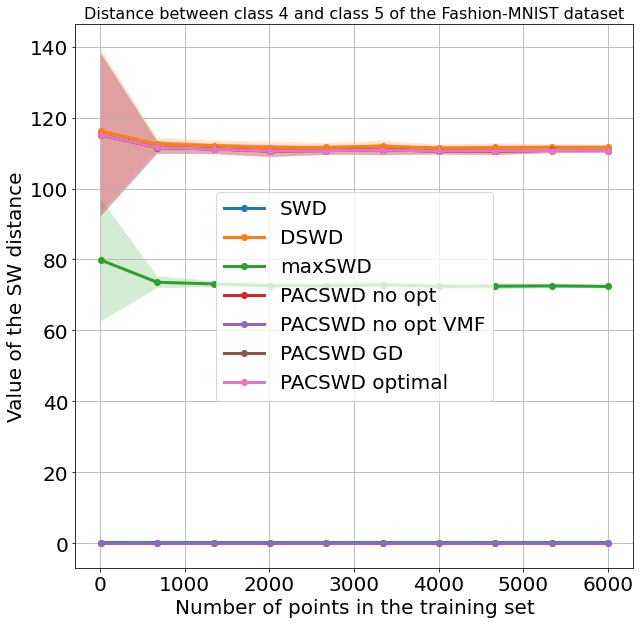

In [5]:
plt.figure(figsize= (10,10))
alldist_swd = np.array(alldist_swd,dtype='float')
alldist_swd_m = alldist_swd.mean(axis=1)
alldist_swd_std = alldist_swd.std(axis=1)

alldist_dswd = np.array(alldist_dswd,dtype='float')
alldist_dswd_m = alldist_dswd.mean(axis=1)
alldist_dswd_std = alldist_dswd.std(axis=1)

alldist_maxswd = np.array(alldist_maxswd,dtype='float')
alldist_maxswd_m = alldist_maxswd.mean(axis=1)
alldist_maxswd_std = alldist_maxswd.std(axis=1)

alldist_swdpac_maxi = np.array(alldist_swdpac_maxi,dtype='float')
alldist_swdpac_maxi_m = alldist_swdpac_maxi.mean(axis=1)
alldist_swdpac_maxi_std = alldist_swdpac_maxi.std(axis=1)


alldist_swdpac_wide = np.array(alldist_swdpac_wide_no_optim,dtype='float')
alldist_swdpac_wide_m = alldist_swdpac_wide_no_optim.mean(axis=1)
alldist_swdpac_wide_std = alldist_swdpac_wide_no_optim.std(axis=1)

alldist_swdpac_wide_vmf = np.array(alldist_swdpac_wide_no_vmf,dtype='float')
alldist_swdpac_wide_vmf_m = alldist_swdpac_wide_no_vmf.mean(axis=1)
alldist_swdpac_wide_vmf_std = alldist_swdpac_wide_no_vmf.std(axis=1)

alldist_swdpac_wide_optimal = np.array(alldist_swdpac_wide_optimal,dtype='float')
alldist_swdpac_wide_optimal_m = alldist_swdpac_wide_optimal.mean(axis=1)
alldist_swdpac_wide_optimal_std = alldist_swdpac_wide_optimal.std(axis=1)

alldist_swdpac_wide_GD = np.array(alldist_swdpac_wide_GD,dtype='float')
alldist_swdpac_wide_GD_m = alldist_swdpac_wide_GD.mean(axis=1)
alldist_swdpac_wide_GD_std = alldist_swdpac_wide_GD.std(axis=1)

fill = True
fs = 20 #fontsize

alpha = 0.2
lw = 3

plt.plot(param_vec,alldist_swd_m,'o-',label=f"SWD", linewidth = lw)

plt.plot(param_vec,alldist_dswd_m,'o-',label=f"DSWD", linewidth = lw)

plt.plot(param_vec,alldist_maxswd_m,'o-',label=f"maxSWD", linewidth = lw)

plt.plot(param_vec,alldist_swdpac_wide_m,'o-',label=f"PACSWD no opt", linewidth = lw)

plt.plot(param_vec,alldist_swdpac_wide_vmf_m,'o-',label=f"PACSWD no opt VMF", linewidth = lw)

plt.plot(param_vec,alldist_swdpac_wide_GD_m,'o-',label=f"PACSWD GD", linewidth = lw)

plt.plot(param_vec,alldist_swdpac_wide_optimal_m,'o-',label=f"PACSWD optimal", linewidth = lw)


if fill == True: 
    plt.fill_between(param_vec, alldist_swd_m-alldist_swd_std, alldist_swd_m+alldist_swd_std, alpha = alpha)
    plt.fill_between(param_vec, alldist_dswd_m-alldist_dswd_std, alldist_dswd_m+alldist_dswd_std, alpha = alpha)
    plt.fill_between(param_vec, alldist_maxswd_m-alldist_maxswd_std, alldist_maxswd_m+alldist_maxswd_std, alpha = alpha)
    plt.fill_between(param_vec, alldist_swdpac_wide_m-alldist_swdpac_wide_std, alldist_swdpac_wide_m+alldist_swdpac_wide_std, alpha = alpha)
    plt.fill_between(param_vec, alldist_swdpac_wide_vmf_m-alldist_swdpac_wide_vmf_std, alldist_swdpac_wide_vmf_m+alldist_swdpac_wide_vmf_std, alpha = alpha)
    plt.fill_between(param_vec, alldist_swdpac_wide_GD_m-alldist_swdpac_wide_GD_std, alldist_swdpac_wide_GD_m+alldist_swdpac_wide_GD_std, alpha = alpha)
    plt.fill_between(param_vec, alldist_swdpac_wide_optimal_m-alldist_swdpac_wide_optimal_std, alldist_swdpac_wide_optimal_m+alldist_swdpac_wide_optimal_std, alpha = alpha)

plt.legend(fontsize = fs);
plt.grid();
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
if data == 'Gaussian':
    plt.xlabel('distance between mean of two Gaussians', fontsize = fs);
    plt.title(f'Gaussians in dimension {dim}', fontsize= 16);
if data == 'Spirals':
    plt.xlabel('Angle between two rotated spirals', fontsize = fs);
if data == 'FMNIST':
    plt.xlabel('Number of points in the training set', fontsize = fs);
    plt.title(f'Distance between class {class_1} and class {class_2} of the Fashion-MNIST dataset', fontsize= 16);
plt.ylabel('Value of the SW distance', fontsize = fs);

In [6]:
#Test set
n_samples_test = 200
alldist_swd_test = np.zeros((nb_compare,nb_iter))
alldist_dswd_test = np.zeros((nb_compare,nb_iter))
alldist_maxswd_test  = np.zeros((nb_compare,nb_iter))
alldist_swdpac_maxi_test  = np.zeros((nb_compare,nb_iter))
alldist_swdpac_wide_no_optim_test  = np.zeros((nb_compare,nb_iter))
alldist_swdpac_wide_optimal_test  = np.zeros((nb_compare,nb_iter))
alldist_swdpac_wide_GD_test  = np.zeros((nb_compare,nb_iter))

for i in tqdm(range(nb_compare)):
   
    for j in range((nb_iter)):
        if data == 'Gaussian':
            Xs =  torch.randn(n_samples,dim).to(device) @ std_1.float().to(device)
            Xt =  torch.randn(n_samples,dim).to(device) @ std_2.float().to(device)+ param_vec[i]
            Xt = Xt.to(device)
        elif data == 'Spiral':
    
            angles=np.linspace(0,np.pi/2,nb_compare)
            Xs,Xt0 = get_data(n_samples_test,0,scale=scale) #was commented
            Xs = torch.from_numpy(Xs).float().to(device)
            
            A = get_rot(angles[i])
            Xt = Xt0.dot(A)
            Xt = torch.from_numpy(Xt).float().to(device)
        elif data == 'FMNIST':
            idx_t = torch.randint(n_test, size=(int(param_vec[i]),))
            Xt = Xt_test[idx_t,:]
        
            idx_s = torch.randint(n_test, size=(int(param_vec[i]),))
            Xs = Xs_test[idx_s,:]
            
        alldist_swd_test[i,j] = sliced_wasserstein_distance(Xs,Xt,device=device,power_p = power_p, num_projections=nproj)    
            
        proj = proj_dswd[i*j]
        distance = sliced_wasserstein_distance(Xs, Xt, proj, nproj, p=2, power_p = power_p, device=device)
        alldist_dswd_test[i, j] = distance.detach().cpu().numpy()    
        
        proj = proj_maxswd[i*j]
        distance = sliced_wasserstein_distance(Xs, Xt, proj, nproj, p=2, power_p = power_p, device=device)
        alldist_maxswd_test[i, j] = distance.detach().cpu().numpy()
        
        proj = proj_no_optim[i*j]
        distance = sliced_wasserstein_distance(Xs, Xt, proj, nproj, p=2, power_p = power_p, device=device)
        alldist_swdpac_wide_no_optim_test[i, j] = distance.detach().cpu().numpy()
        
        proj = proj_GD[i*j]
        distance = sliced_wasserstein_distance(Xs, Xt, proj, nproj, p=2, power_p = power_p, device=device)
        alldist_swdpac_wide_GD_test[i, j] = distance.detach().cpu().numpy()
        
        proj = proj_optimal[i*j]
        distance = sliced_wasserstein_distance(Xs, Xt, proj, nproj, p=2, power_p = power_p, device=device)
        alldist_swdpac_wide_optimal_test[i, j] = distance.detach().cpu().numpy()

100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


In [7]:
alldist_swd_test = np.array(alldist_swd_test,dtype='float')
alldist_swd_test_m = alldist_swd_test.mean(axis=1)
alldist_swd_test_std = alldist_swd_test.std(axis=1)

alldist_dswd_test = np.array(alldist_dswd_test,dtype='float')
alldist_dswd_test_m = alldist_dswd_test.mean(axis=1)
alldist_dswd_test_std = alldist_dswd_test.std(axis=1)

alldist_maxswd_test = np.array(alldist_maxswd_test,dtype='float')
alldist_maxswd_test_m = alldist_maxswd_test.mean(axis=1)
alldist_maxswd_test_std = alldist_maxswd_test.std(axis=1)

alldist_swdpac_wide_test = np.array(alldist_swdpac_wide_no_optim_test,dtype='float')
alldist_swdpac_wide_test_m = alldist_swdpac_wide_no_optim_test.mean(axis=1)
alldist_swdpac_wide_test_std = alldist_swdpac_wide_no_optim_test.std(axis=1)

alldist_swdpac_wide_optimal_test = np.array(alldist_swdpac_wide_optimal_test,dtype='float')
alldist_swdpac_wide_optimal_test_m = alldist_swdpac_wide_optimal_test.mean(axis=1)
alldist_swdpac_wide_optimal_test_std = alldist_swdpac_wide_optimal_test.std(axis=1)

alldist_swdpac_wide_GD_test = np.array(alldist_swdpac_wide_GD_test,dtype='float')
alldist_swdpac_wide_GD_test_m = alldist_swdpac_wide_GD_test.mean(axis=1)
alldist_swdpac_wide_GD_test_std = alldist_swdpac_wide_GD_test.std(axis=1)


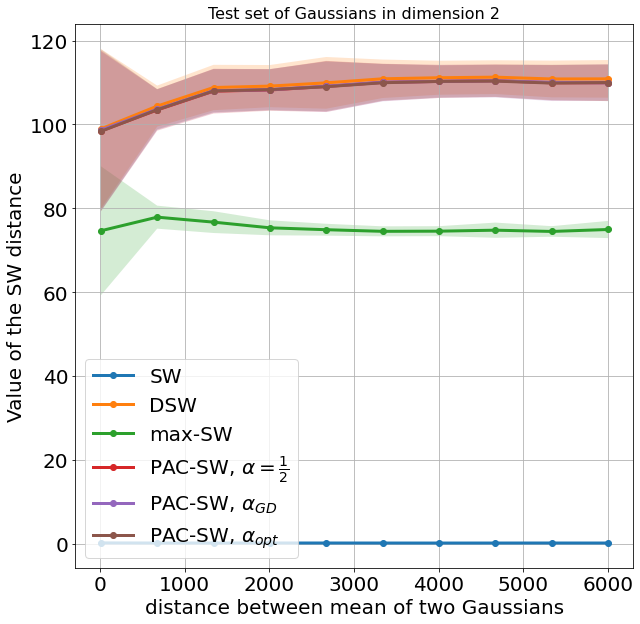

In [8]:
plt.figure(figsize= (10,10))
plt.plot(param_vec,  alldist_swd_test_m,'o-',label="SW", linewidth = lw);
plt.plot(param_vec,  alldist_dswd_test_m,'o-',label="DSW", linewidth = lw);
plt.plot(param_vec,  alldist_maxswd_test_m,'o-',label="max-SW", linewidth = lw);
plt.plot(param_vec,  alldist_swdpac_wide_test_m,'o-',label=r"PAC-SW, $\alpha = \frac{1}{2}$", linewidth = lw);
plt.plot(param_vec,  alldist_swdpac_wide_GD_test_m,'o-', label=r"PAC-SW, $\alpha_{GD}$", linewidth = lw);
plt.plot(param_vec,  alldist_swdpac_wide_optimal_test_m,'o-',label=r"PAC-SW, $\alpha_{opt}$", linewidth = lw);

fill = True
if fill == True: 
    plt.fill_between(param_vec, alldist_swd_test_m-alldist_swd_test_std, alldist_swd_test_m+alldist_swd_test_std, alpha = alpha)
    plt.fill_between(param_vec, alldist_dswd_test_m-alldist_dswd_test_std, alldist_dswd_test_m+alldist_dswd_test_std, alpha = alpha)
    plt.fill_between(param_vec, alldist_maxswd_test_m-alldist_maxswd_test_std, alldist_maxswd_test_m+alldist_maxswd_test_std, alpha = alpha)
    plt.fill_between(param_vec, alldist_swdpac_wide_test_m-alldist_swdpac_wide_test_std, alldist_swdpac_wide_test_m+alldist_swdpac_wide_test_std, alpha = alpha)
    plt.fill_between(param_vec, alldist_swdpac_wide_optimal_test_m-alldist_swdpac_wide_optimal_test_std, alldist_swdpac_wide_optimal_test_m+alldist_swdpac_wide_optimal_test_std, alpha = alpha)
    plt.fill_between(param_vec, alldist_swdpac_wide_GD_test_m-alldist_swdpac_wide_GD_test_std, alldist_swdpac_wide_GD_test_m+alldist_swdpac_wide_GD_test_std, alpha = alpha)

plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.xlabel('distance between mean of two Gaussians', fontsize = fs);
plt.ylabel('Value of the SW distance', fontsize = fs);
plt.title('Test set of Gaussians in dimension 2', fontsize= 16);
plt.legend(fontsize = fs);
plt.grid();
if data == 'Gaussian':
    plt.xlabel('distance between mean of two Gaussians', fontsize = fs);
    plt.title(f'Gaussians in dimension {dim}', fontsize= 16);
if data == 'Spirals':
    plt.xlabel('Angle between two rotated spirals', fontsize = fs);
if data == 'FMNIST':
    plt.xlabel('Number of points in the training set', fontsize = fs);
    plt.title(f'Distance between class {class_1} and class {class_2} of the Fashion-MNIST dataset', fontsize= 16);
plt.ylabel('Value of the SW distance', fontsize = fs);

In [9]:
if not os.path.exists(f'result/{data}_{same_cov}_dim{dim}'):
    os.makedirs(f'result/{data}_{same_cov}_dim{dim}')

np.save(f'result/{data}_{same_cov}_dim{dim}/SW{nproj}_train{n_samples}_nproj{nproj}', alldist_swd)
np.save(f'result/{data}_{same_cov}_dim{dim}/DSW{nproj}_train{n_samples}_nproj{nproj}_lr{int(lr_dswd*1000)}_lam{lam}', alldist_dswd)
np.save(f'result/{data}_{same_cov}_dim{dim}/maxSW_train{n_samples}_lr{int(lr_maxswd*1000)}', alldist_maxswd)
np.save(f'result/{data}_{same_cov}_dim{dim}/PACSW{nproj}_no-optim_train{n_samples}_nproj{nproj}_lr{int(lr_pac_no_optim *1000)}', alldist_swdpac_wide_no_optim)
np.save(f'result/{data}_{same_cov}_dim{dim}/PACSW{nproj}_optimal_train{n_samples}_nproj{nproj}_lr{int(lr_pac_optimal*1000)}_optimal', alldist_swdpac_wide_optimal)
np.save(f'result/{data}_{same_cov}_dim{dim}/PACSW{nproj}_GD_train{n_samples}_nproj{nproj}_lr{int(lr_pac_GD*1000)}_GD', alldist_swdpac_wide_GD)
np.save(f'result/{data}_{same_cov}_dim{dim}/param_vec', param_vec)

np.save(f'result/{data}_{same_cov}_dim{dim}/SW{nproj}_test{n_samples_test}_tr{n_samples}_nproj{nproj}', alldist_swd_test)
np.save(f'result/{data}_{same_cov}_dim{dim}/DSW{nproj}_test{n_samples_test}_tr{n_samples}_nproj{nproj}_lr{int(lr_dswd*1000)}_lam{lam}', alldist_dswd_test)
np.save(f'result/{data}_{same_cov}_dim{dim}/maxSW_test{n_samples_test}_tr{n_samples}_lr{int(lr_maxswd*1000)}', alldist_maxswd_test)
np.save(f'result/{data}_{same_cov}_dim{dim}/PACSW{nproj}_no-optim_test{n_samples_test}_tr{n_samples}_nproj{nproj}_lr{int(lr_pac_no_optim *1000)}', alldist_swdpac_wide_no_optim_test)
np.save(f'result/{data}_{same_cov}_dim{dim}/PACSW{nproj}_optimal_test{n_samples_test}_tr{n_samples}_nproj{nproj}_lr{int(lr_pac_optimal*1000)}_optimal', alldist_swdpac_wide_optimal_test)
np.save(f'result/{data}_{same_cov}_dim{dim}/PACSW{nproj}_GD_test{n_samples_test}_tr{n_samples}_nproj{nproj}_lr{int(lr_pac_GD*1000)}_GD', alldist_swdpac_wide_GD_test)
np.save(f'result/{data}_{same_cov}_dim{dim}/param_vec', param_vec)

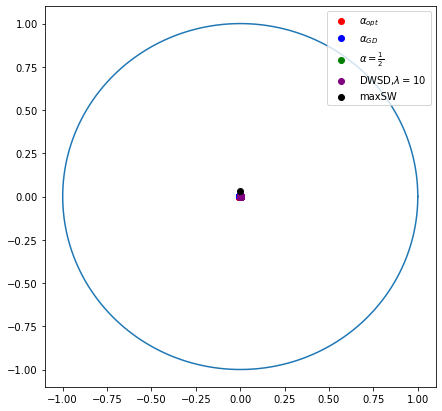

In [10]:
N = 400
t = np.linspace(0, 2 * np.pi, N)
r = 1 
x, y = r * np.cos(t), r * np.sin(t)
plt.figure(figsize=(7,7))
plt.plot(x,y)

plt.scatter(final_projections_optimal[:,0].detach().cpu().numpy(), final_projections_optimal[:,1].detach().cpu().numpy(), color='r', label= r'$\alpha_{opt}$');
plt.scatter(final_projections_GD[:,0].detach().cpu().numpy(), final_projections_GD[:,1].detach().cpu().numpy(), color='b', label= r'$\alpha_{GD}$');
plt.scatter(final_projections_no_optim[:,0].detach().cpu().numpy(), final_projections_no_optim[:,1].detach().cpu().numpy(), color='g', label= r'$\alpha=\frac{1}{2}$');
plt.scatter(final_proj_dswd[:,0].detach().cpu().numpy(), final_proj_dswd[:,1].detach().cpu().numpy(), color='purple', label= r'DWSD,$\lambda = 10$ ');
plt.scatter(maxi[:,0].detach().cpu().numpy(), maxi[:,1].detach().cpu().numpy(), color='black', label= 'maxSW');


plt.legend();